In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 4
ROOT_DIR = '/kaggle/input/parasitized/Parasitized'

In [3]:
class MalariaDataset(Dataset):
    def __init__(self, image_files, root_dir, transform=None):
        self.image_files = image_files
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        mask_name = img_name.replace('.png', '_mask.png')
        mask_path = os.path.join(self.root_dir, mask_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Mask as grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

all_image_files = [f for f in os.listdir(ROOT_DIR) if f.endswith('.png') and '_mask' not in f]

# Split into train and test sets
train_files, test_files = train_test_split(all_image_files, test_size=0.2, random_state=42)

# Create datasets
train_dataset = MalariaDataset(train_files, ROOT_DIR, transform=transform)
test_dataset = MalariaDataset(test_files, ROOT_DIR, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Training batch - images shape: torch.Size([4, 3, 128, 128]), masks shape: torch.Size([4, 1, 128, 128])


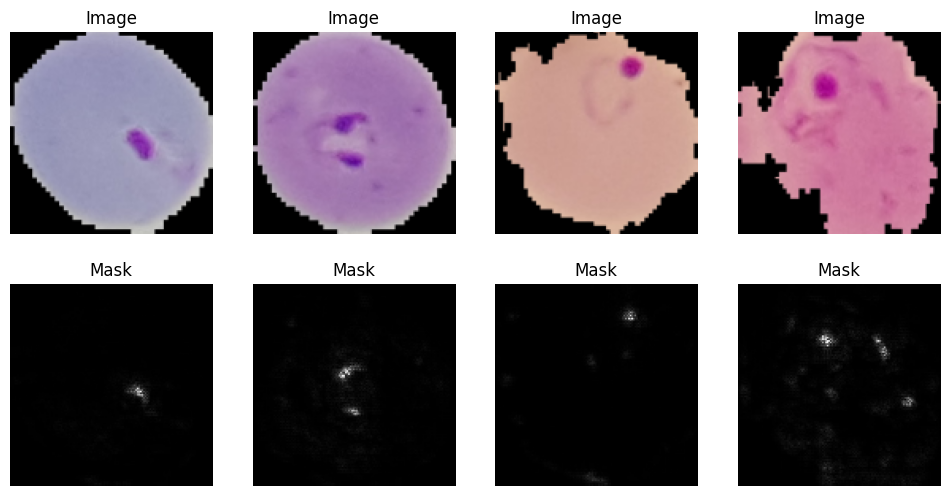

Testing batch - images shape: torch.Size([4, 3, 128, 128]), masks shape: torch.Size([4, 1, 128, 128])


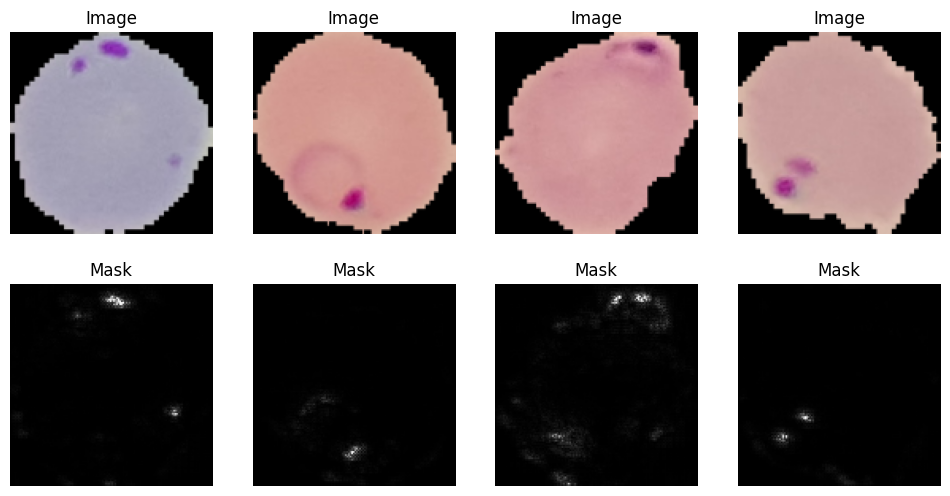

In [5]:

# Function to display images and masks
def show_images(images, masks):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].set_title('Image')
        axes[0, i].axis('off')
        axes[1, i].imshow(masks[i][0], cmap='gray')
        axes[1, i].set_title('Mask')
        axes[1, i].axis('off')
    plt.show()

# Get a batch of images and masks from the training set
train_iter = iter(train_loader)
train_images, train_masks = next(train_iter)
print(f"Training batch - images shape: {train_images.shape}, masks shape: {train_masks.shape}")
show_images(train_images, train_masks)

# Get a batch of images and masks from the testing set
test_iter = iter(test_loader)
test_images, test_masks = next(test_iter)
print(f"Testing batch - images shape: {test_images.shape}, masks shape: {test_masks.shape}")
show_images(test_images, test_masks)

In [6]:
# Print the number of batches in the train and test loaders
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in train loader: 2756
Number of batches in test loader: 689


# Model Creation

In [7]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

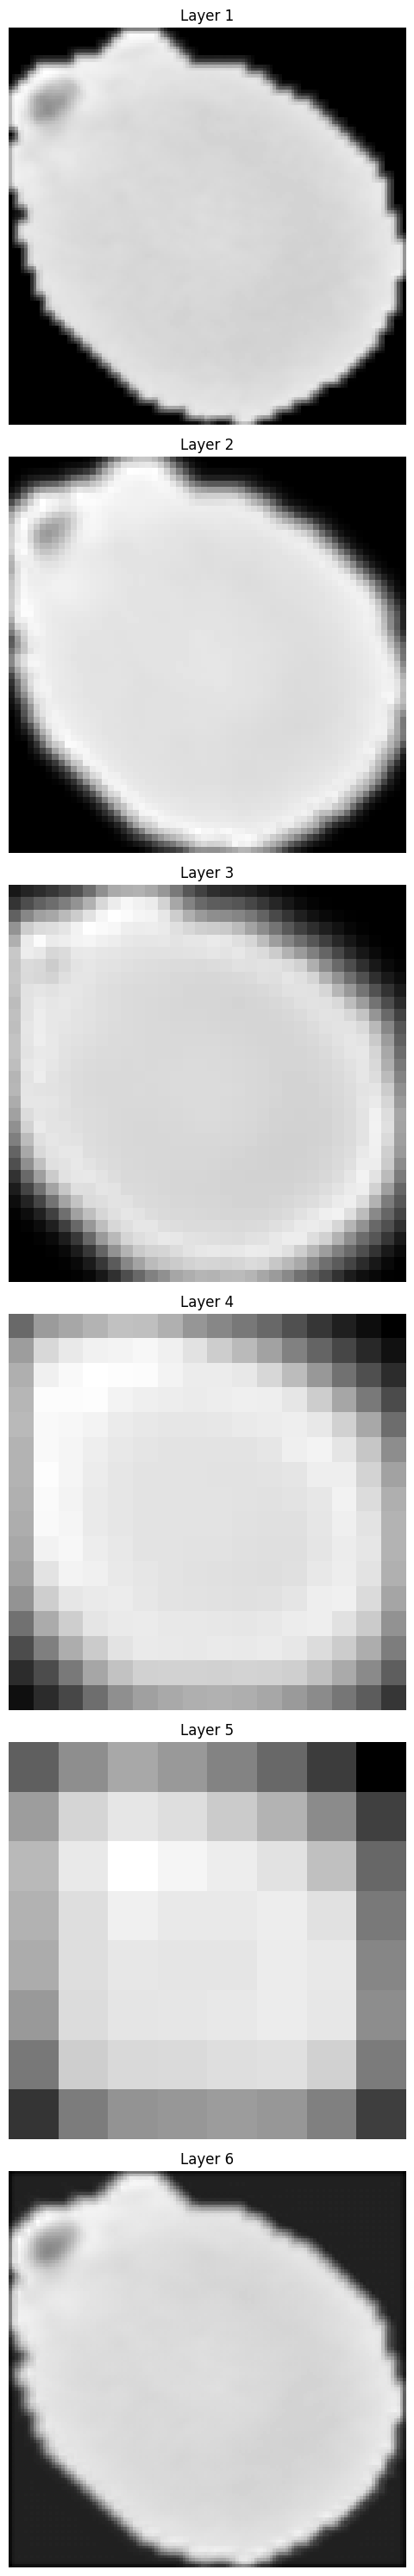

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_intermediate_outputs(model, images):
    model.eval()
    x = images
    x1 = model.inc(x)
    x2 = model.down1(x1)
    x3 = model.down2(x2)
    x4 = model.down3(x3)
    x5 = model.down4(x4)
    x = model.up1(x5, x4)
    x = model.up2(x, x3)
    x = model.up3(x, x2)
    x = model.up4(x, x1)
    
    intermediate_outputs = [x1, x2, x3, x4, x5, x]

    # Number of layers
    num_layers = len(intermediate_outputs)
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, num_layers * 5))
    
    if num_layers == 1:
        axes = [axes]

    for i in range(num_layers):
        # Take the first image from the batch and the first channel of the output
        out = intermediate_outputs[i][0].detach().numpy()  # Shape [C, H, W]
        out = np.mean(out, axis=0)  # Convert to [H, W] by averaging over channels if needed
        out = (out - out.min()) / (out.max() - out.min())  # Normalize to [0, 1]

        axes[i].imshow(out, cmap='gray')
        axes[i].set_title(f'Layer {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
model = UNet(n_channels=3, n_classes=1)
model.eval()

# Load a batch of data
for images, masks in train_loader:

    with torch.no_grad():
        # Visualize intermediate outputs
        visualize_intermediate_outputs(model, images)
    break

In [10]:
# Function to display images and masks
def compare_segmented(images, outputs, masks):
    fig, axes = plt.subplots(len(images), 3, figsize=(10, len(images) * 5))
    
    if len(images) == 1:
        axes = [axes]
    
    for i in range(len(images)):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        output = outputs[i][0]  # Since n_classes=1, take the first channel
        output = (output - output.min()) / (output.max() - output.min())  # Normalize to [0, 1]
        mask = masks[i][0].cpu().numpy()

        axes[i][0].imshow(image)
        axes[i][0].set_title('Input Image')
        axes[i][0].axis('off')

        axes[i][1].imshow(output, cmap='gray')
        axes[i][1].set_title('Predicted Segmentation')
        axes[i][1].axis('off')

        axes[i][2].imshow(mask, cmap='gray')
        axes[i][2].set_title('Ground Truth Mask')
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()

### Checking if model is functional before training

Output shape:  (4, 1, 128, 128)


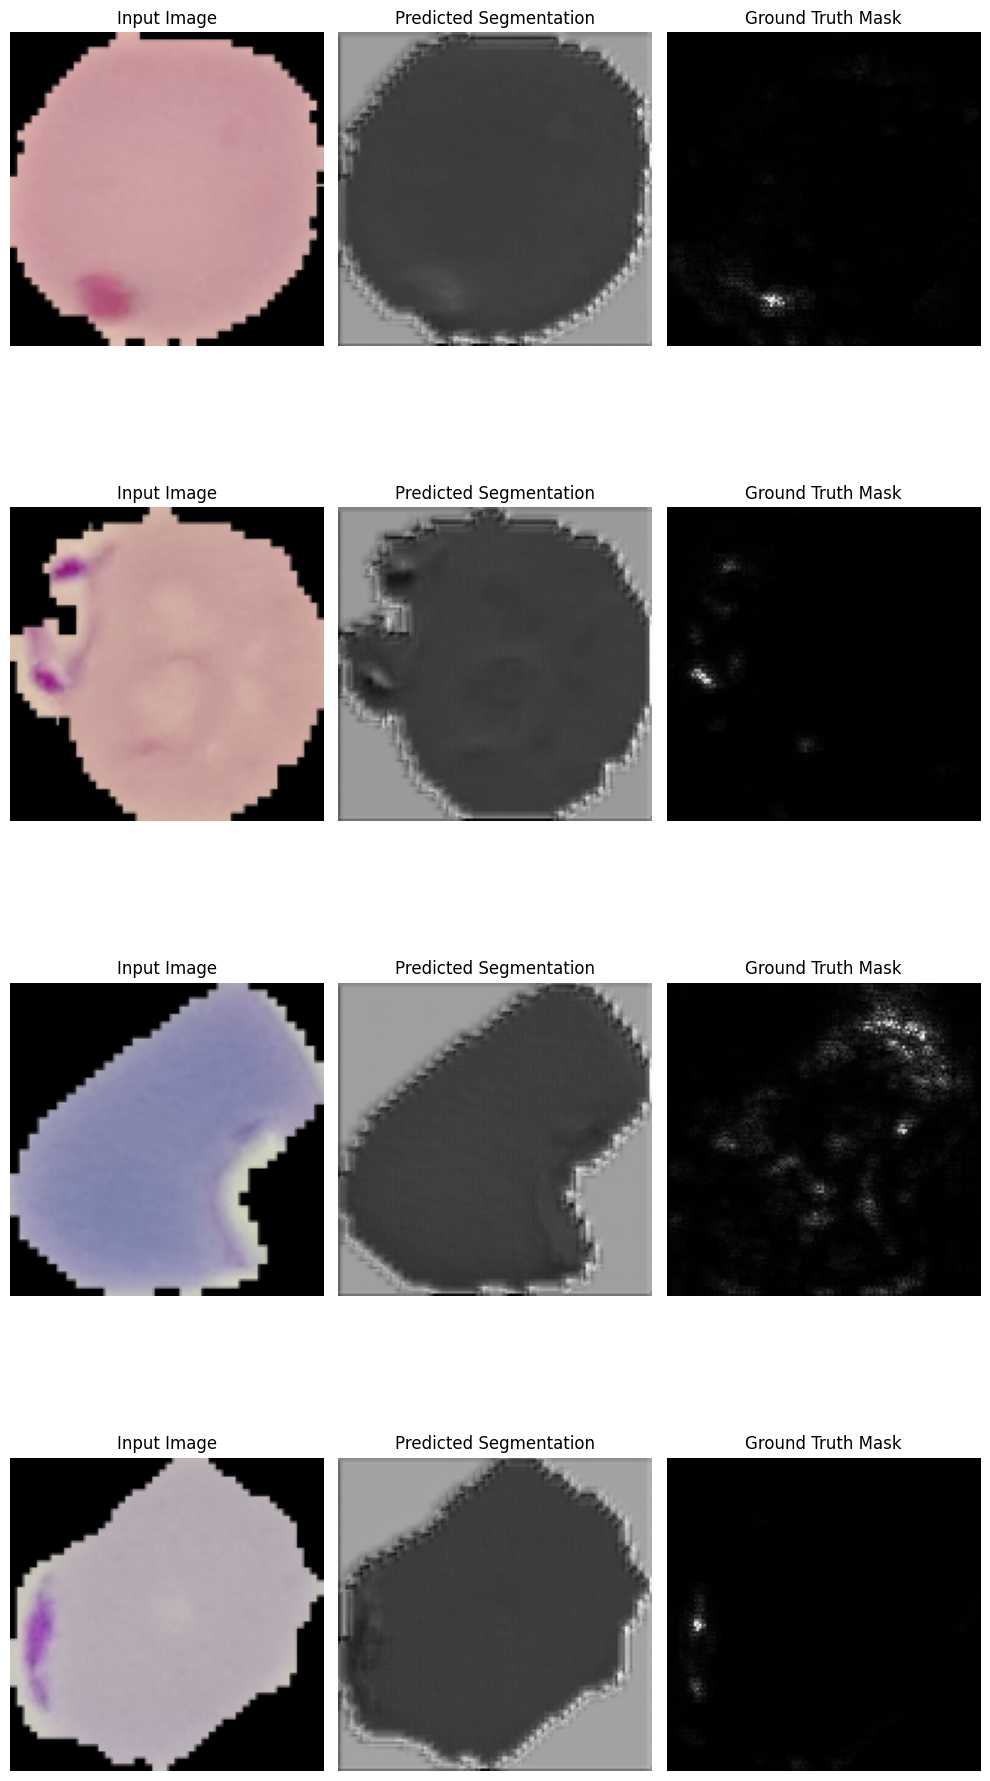

In [11]:
model = UNet(n_channels=3, n_classes=1) # Assuming binary segmentation
model.eval()

# Load a batch of data
for images, masks in train_loader:
    # Perform inference
    with torch.no_grad():
        outputs = model(images)
    
    # Convert outputs to numpy for visualization
    outputs = outputs.detach().numpy()

    print("Output shape: ", outputs.shape)
    
    # Visualize the results
    compare_segmented(images, outputs, masks)
    
    # Break after one batch for demonstration
    break

### Loss function and training loop

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice


def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25, device='cuda', save_path='model.pth'):
    model = model.to(device)
    best_loss = float('inf')
    train_dice_scores = []
    test_dice_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_dice_epoch = []

        for inputs, masks in tqdm(train_loader):
            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_dice_epoch.append(dice_coefficient(outputs, masks))

        epoch_loss = running_loss / len(train_loader.dataset)
        train_dice_scores.append(sum(train_dice_epoch) / len(train_dice_epoch))
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Dice: {train_dice_scores[-1]:.4f}')

        # Evaluate on the test set
        model.eval()
        test_dice_epoch = []
        with torch.no_grad():
            for inputs, masks in test_loader:
                inputs = inputs.to(device)
                masks = masks.to(device)

                outputs = model(inputs)
                test_dice_epoch.append(dice_coefficient(outputs, masks))

        test_dice_scores.append(sum(test_dice_epoch) / len(test_dice_epoch))
        print(f'Test Dice: {test_dice_scores[-1]:.4f}')

        # Save the model if it has the best loss so far
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
            print(f'Model weights saved at epoch {epoch} with loss {epoch_loss:.4f}')

    return model, train_dice_scores, test_dice_scores

In [13]:
def dice_coefficient(inputs, targets, smooth=1):
    inputs = torch.sigmoid(inputs)
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return dice.item()

### Training

In [14]:
model = UNet(n_channels=3, n_classes=1)  # Assuming binary segmentation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
num_epochs = 64
model, train_dice_scores, test_dice_scores = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device='cuda', save_path='unet_best_model.pth')

100%|██████████| 2756/2756 [05:11<00:00,  8.85it/s]


Epoch 0/63, Loss: 0.8695, Train Dice: 0.1305
Test Dice: 0.1388
Model weights saved at epoch 0 with loss 0.8695


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 1/63, Loss: 0.8623, Train Dice: 0.1377
Test Dice: 0.1402
Model weights saved at epoch 1 with loss 0.8623


100%|██████████| 2756/2756 [03:57<00:00, 11.63it/s]


Epoch 2/63, Loss: 0.8600, Train Dice: 0.1400
Test Dice: 0.1420
Model weights saved at epoch 2 with loss 0.8600


100%|██████████| 2756/2756 [03:57<00:00, 11.60it/s]


Epoch 3/63, Loss: 0.8580, Train Dice: 0.1420
Test Dice: 0.1453
Model weights saved at epoch 3 with loss 0.8580


100%|██████████| 2756/2756 [03:56<00:00, 11.63it/s]


Epoch 4/63, Loss: 0.8563, Train Dice: 0.1437
Test Dice: 0.1453
Model weights saved at epoch 4 with loss 0.8563


100%|██████████| 2756/2756 [03:56<00:00, 11.63it/s]


Epoch 5/63, Loss: 0.8550, Train Dice: 0.1450
Test Dice: 0.1467
Model weights saved at epoch 5 with loss 0.8550


100%|██████████| 2756/2756 [03:57<00:00, 11.63it/s]


Epoch 6/63, Loss: 0.8537, Train Dice: 0.1463
Test Dice: 0.1474
Model weights saved at epoch 6 with loss 0.8537


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 7/63, Loss: 0.8530, Train Dice: 0.1470
Test Dice: 0.1473
Model weights saved at epoch 7 with loss 0.8530


100%|██████████| 2756/2756 [03:56<00:00, 11.66it/s]


Epoch 8/63, Loss: 0.8523, Train Dice: 0.1477
Test Dice: 0.1496
Model weights saved at epoch 8 with loss 0.8523


100%|██████████| 2756/2756 [03:56<00:00, 11.68it/s]


Epoch 9/63, Loss: 0.8516, Train Dice: 0.1484
Test Dice: 0.1484
Model weights saved at epoch 9 with loss 0.8516


100%|██████████| 2756/2756 [03:56<00:00, 11.66it/s]


Epoch 10/63, Loss: 0.8511, Train Dice: 0.1489
Test Dice: 0.1495
Model weights saved at epoch 10 with loss 0.8511


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 11/63, Loss: 0.8506, Train Dice: 0.1494
Test Dice: 0.1491
Model weights saved at epoch 11 with loss 0.8506


100%|██████████| 2756/2756 [03:57<00:00, 11.62it/s]


Epoch 12/63, Loss: 0.8499, Train Dice: 0.1501
Test Dice: 0.1481
Model weights saved at epoch 12 with loss 0.8499


100%|██████████| 2756/2756 [03:56<00:00, 11.65it/s]


Epoch 13/63, Loss: 0.8495, Train Dice: 0.1505
Test Dice: 0.1492
Model weights saved at epoch 13 with loss 0.8495


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 14/63, Loss: 0.8492, Train Dice: 0.1508
Test Dice: 0.1492
Model weights saved at epoch 14 with loss 0.8492


100%|██████████| 2756/2756 [03:56<00:00, 11.63it/s]


Epoch 15/63, Loss: 0.8487, Train Dice: 0.1513
Test Dice: 0.1501
Model weights saved at epoch 15 with loss 0.8487


100%|██████████| 2756/2756 [04:04<00:00, 11.27it/s]


Epoch 16/63, Loss: 0.8485, Train Dice: 0.1515
Test Dice: 0.1500
Model weights saved at epoch 16 with loss 0.8485


100%|██████████| 2756/2756 [03:56<00:00, 11.63it/s]


Epoch 17/63, Loss: 0.8480, Train Dice: 0.1520
Test Dice: 0.1492
Model weights saved at epoch 17 with loss 0.8480


100%|██████████| 2756/2756 [03:57<00:00, 11.62it/s]


Epoch 18/63, Loss: 0.8476, Train Dice: 0.1524
Test Dice: 0.1501
Model weights saved at epoch 18 with loss 0.8476


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 19/63, Loss: 0.8475, Train Dice: 0.1525
Test Dice: 0.1494
Model weights saved at epoch 19 with loss 0.8475


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 20/63, Loss: 0.8470, Train Dice: 0.1530
Test Dice: 0.1504
Model weights saved at epoch 20 with loss 0.8470


100%|██████████| 2756/2756 [03:55<00:00, 11.69it/s]


Epoch 21/63, Loss: 0.8468, Train Dice: 0.1532
Test Dice: 0.1498
Model weights saved at epoch 21 with loss 0.8468


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 22/63, Loss: 0.8462, Train Dice: 0.1538
Test Dice: 0.1504
Model weights saved at epoch 22 with loss 0.8462


100%|██████████| 2756/2756 [03:56<00:00, 11.68it/s]


Epoch 23/63, Loss: 0.8460, Train Dice: 0.1540
Test Dice: 0.1504
Model weights saved at epoch 23 with loss 0.8460


100%|██████████| 2756/2756 [03:55<00:00, 11.68it/s]


Epoch 24/63, Loss: 0.8459, Train Dice: 0.1541
Test Dice: 0.1517
Model weights saved at epoch 24 with loss 0.8459


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 25/63, Loss: 0.8454, Train Dice: 0.1546
Test Dice: 0.1510
Model weights saved at epoch 25 with loss 0.8454


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 26/63, Loss: 0.8453, Train Dice: 0.1547
Test Dice: 0.1514
Model weights saved at epoch 26 with loss 0.8453


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 27/63, Loss: 0.8449, Train Dice: 0.1551
Test Dice: 0.1520
Model weights saved at epoch 27 with loss 0.8449


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 28/63, Loss: 0.8447, Train Dice: 0.1553
Test Dice: 0.1503
Model weights saved at epoch 28 with loss 0.8447


100%|██████████| 2756/2756 [03:56<00:00, 11.65it/s]


Epoch 29/63, Loss: 0.8441, Train Dice: 0.1559
Test Dice: 0.1512
Model weights saved at epoch 29 with loss 0.8441


100%|██████████| 2756/2756 [03:57<00:00, 11.58it/s]


Epoch 30/63, Loss: 0.8440, Train Dice: 0.1560
Test Dice: 0.1505
Model weights saved at epoch 30 with loss 0.8440


100%|██████████| 2756/2756 [03:57<00:00, 11.62it/s]


Epoch 31/63, Loss: 0.8437, Train Dice: 0.1563
Test Dice: 0.1517
Model weights saved at epoch 31 with loss 0.8437


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 32/63, Loss: 0.8435, Train Dice: 0.1565
Test Dice: 0.1519
Model weights saved at epoch 32 with loss 0.8435


100%|██████████| 2756/2756 [03:56<00:00, 11.65it/s]


Epoch 33/63, Loss: 0.8432, Train Dice: 0.1568
Test Dice: 0.1516
Model weights saved at epoch 33 with loss 0.8432


100%|██████████| 2756/2756 [03:57<00:00, 11.63it/s]


Epoch 34/63, Loss: 0.8427, Train Dice: 0.1573
Test Dice: 0.1518
Model weights saved at epoch 34 with loss 0.8427


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 35/63, Loss: 0.8424, Train Dice: 0.1576
Test Dice: 0.1519
Model weights saved at epoch 35 with loss 0.8424


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 36/63, Loss: 0.8421, Train Dice: 0.1579
Test Dice: 0.1523
Model weights saved at epoch 36 with loss 0.8421


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 37/63, Loss: 0.8419, Train Dice: 0.1581
Test Dice: 0.1521
Model weights saved at epoch 37 with loss 0.8419


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 38/63, Loss: 0.8416, Train Dice: 0.1584
Test Dice: 0.1510
Model weights saved at epoch 38 with loss 0.8416


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 39/63, Loss: 0.8415, Train Dice: 0.1585
Test Dice: 0.1522
Model weights saved at epoch 39 with loss 0.8415


100%|██████████| 2756/2756 [03:57<00:00, 11.63it/s]


Epoch 40/63, Loss: 0.8411, Train Dice: 0.1589
Test Dice: 0.1513
Model weights saved at epoch 40 with loss 0.8411


100%|██████████| 2756/2756 [03:57<00:00, 11.63it/s]


Epoch 41/63, Loss: 0.8407, Train Dice: 0.1593
Test Dice: 0.1520
Model weights saved at epoch 41 with loss 0.8407


100%|██████████| 2756/2756 [03:56<00:00, 11.65it/s]


Epoch 42/63, Loss: 0.8405, Train Dice: 0.1595
Test Dice: 0.1521
Model weights saved at epoch 42 with loss 0.8405


100%|██████████| 2756/2756 [03:56<00:00, 11.65it/s]


Epoch 43/63, Loss: 0.8402, Train Dice: 0.1598
Test Dice: 0.1515
Model weights saved at epoch 43 with loss 0.8402


100%|██████████| 2756/2756 [03:56<00:00, 11.65it/s]


Epoch 44/63, Loss: 0.8399, Train Dice: 0.1601
Test Dice: 0.1518
Model weights saved at epoch 44 with loss 0.8399


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 45/63, Loss: 0.8397, Train Dice: 0.1603
Test Dice: 0.1522
Model weights saved at epoch 45 with loss 0.8397


100%|██████████| 2756/2756 [03:56<00:00, 11.66it/s]


Epoch 46/63, Loss: 0.8393, Train Dice: 0.1607
Test Dice: 0.1516
Model weights saved at epoch 46 with loss 0.8393


100%|██████████| 2756/2756 [03:56<00:00, 11.65it/s]


Epoch 47/63, Loss: 0.8391, Train Dice: 0.1609
Test Dice: 0.1517
Model weights saved at epoch 47 with loss 0.8391


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 48/63, Loss: 0.8388, Train Dice: 0.1612
Test Dice: 0.1505
Model weights saved at epoch 48 with loss 0.8388


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 49/63, Loss: 0.8384, Train Dice: 0.1616
Test Dice: 0.1519
Model weights saved at epoch 49 with loss 0.8384


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 50/63, Loss: 0.8383, Train Dice: 0.1617
Test Dice: 0.1521
Model weights saved at epoch 50 with loss 0.8383


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 51/63, Loss: 0.8379, Train Dice: 0.1620
Test Dice: 0.1520
Model weights saved at epoch 51 with loss 0.8379


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 52/63, Loss: 0.8379, Train Dice: 0.1621
Test Dice: 0.1527
Model weights saved at epoch 52 with loss 0.8379


100%|██████████| 2756/2756 [03:57<00:00, 11.62it/s]


Epoch 53/63, Loss: 0.8376, Train Dice: 0.1624
Test Dice: 0.1514
Model weights saved at epoch 53 with loss 0.8376


100%|██████████| 2756/2756 [03:57<00:00, 11.62it/s]


Epoch 54/63, Loss: 0.8374, Train Dice: 0.1626
Test Dice: 0.1518
Model weights saved at epoch 54 with loss 0.8374


100%|██████████| 2756/2756 [03:56<00:00, 11.65it/s]


Epoch 55/63, Loss: 0.8372, Train Dice: 0.1628
Test Dice: 0.1504
Model weights saved at epoch 55 with loss 0.8372


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 56/63, Loss: 0.8367, Train Dice: 0.1633
Test Dice: 0.1512
Model weights saved at epoch 56 with loss 0.8367


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 57/63, Loss: 0.8365, Train Dice: 0.1635
Test Dice: 0.1513
Model weights saved at epoch 57 with loss 0.8365


100%|██████████| 2756/2756 [03:56<00:00, 11.68it/s]


Epoch 58/63, Loss: 0.8365, Train Dice: 0.1635
Test Dice: 0.1515


100%|██████████| 2756/2756 [03:56<00:00, 11.66it/s]


Epoch 59/63, Loss: 0.8364, Train Dice: 0.1636
Test Dice: 0.1523
Model weights saved at epoch 59 with loss 0.8364


100%|██████████| 2756/2756 [03:57<00:00, 11.62it/s]


Epoch 60/63, Loss: 0.8360, Train Dice: 0.1640
Test Dice: 0.1506
Model weights saved at epoch 60 with loss 0.8360


100%|██████████| 2756/2756 [03:56<00:00, 11.67it/s]


Epoch 61/63, Loss: 0.8360, Train Dice: 0.1640
Test Dice: 0.1513
Model weights saved at epoch 61 with loss 0.8360


100%|██████████| 2756/2756 [03:56<00:00, 11.64it/s]


Epoch 62/63, Loss: 0.8356, Train Dice: 0.1644
Test Dice: 0.1514
Model weights saved at epoch 62 with loss 0.8356


100%|██████████| 2756/2756 [03:56<00:00, 11.65it/s]


Epoch 63/63, Loss: 0.8354, Train Dice: 0.1646
Test Dice: 0.1518
Model weights saved at epoch 63 with loss 0.8354


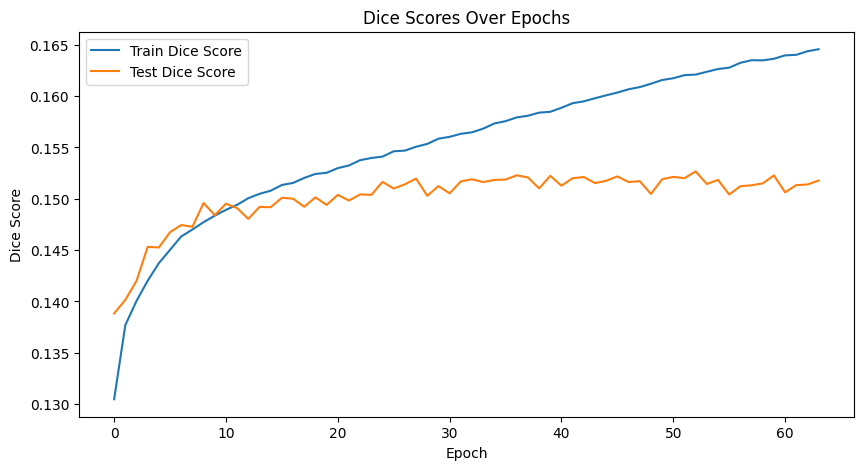

In [16]:
# Plotting the Dice scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_dice_scores, label='Train Dice Score')
plt.plot(test_dice_scores, label='Test Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.title('Dice Scores Over Epochs')
plt.show()

### Visualizing segmented train and test images vs ground truth

Output shape:  (4, 1, 128, 128)


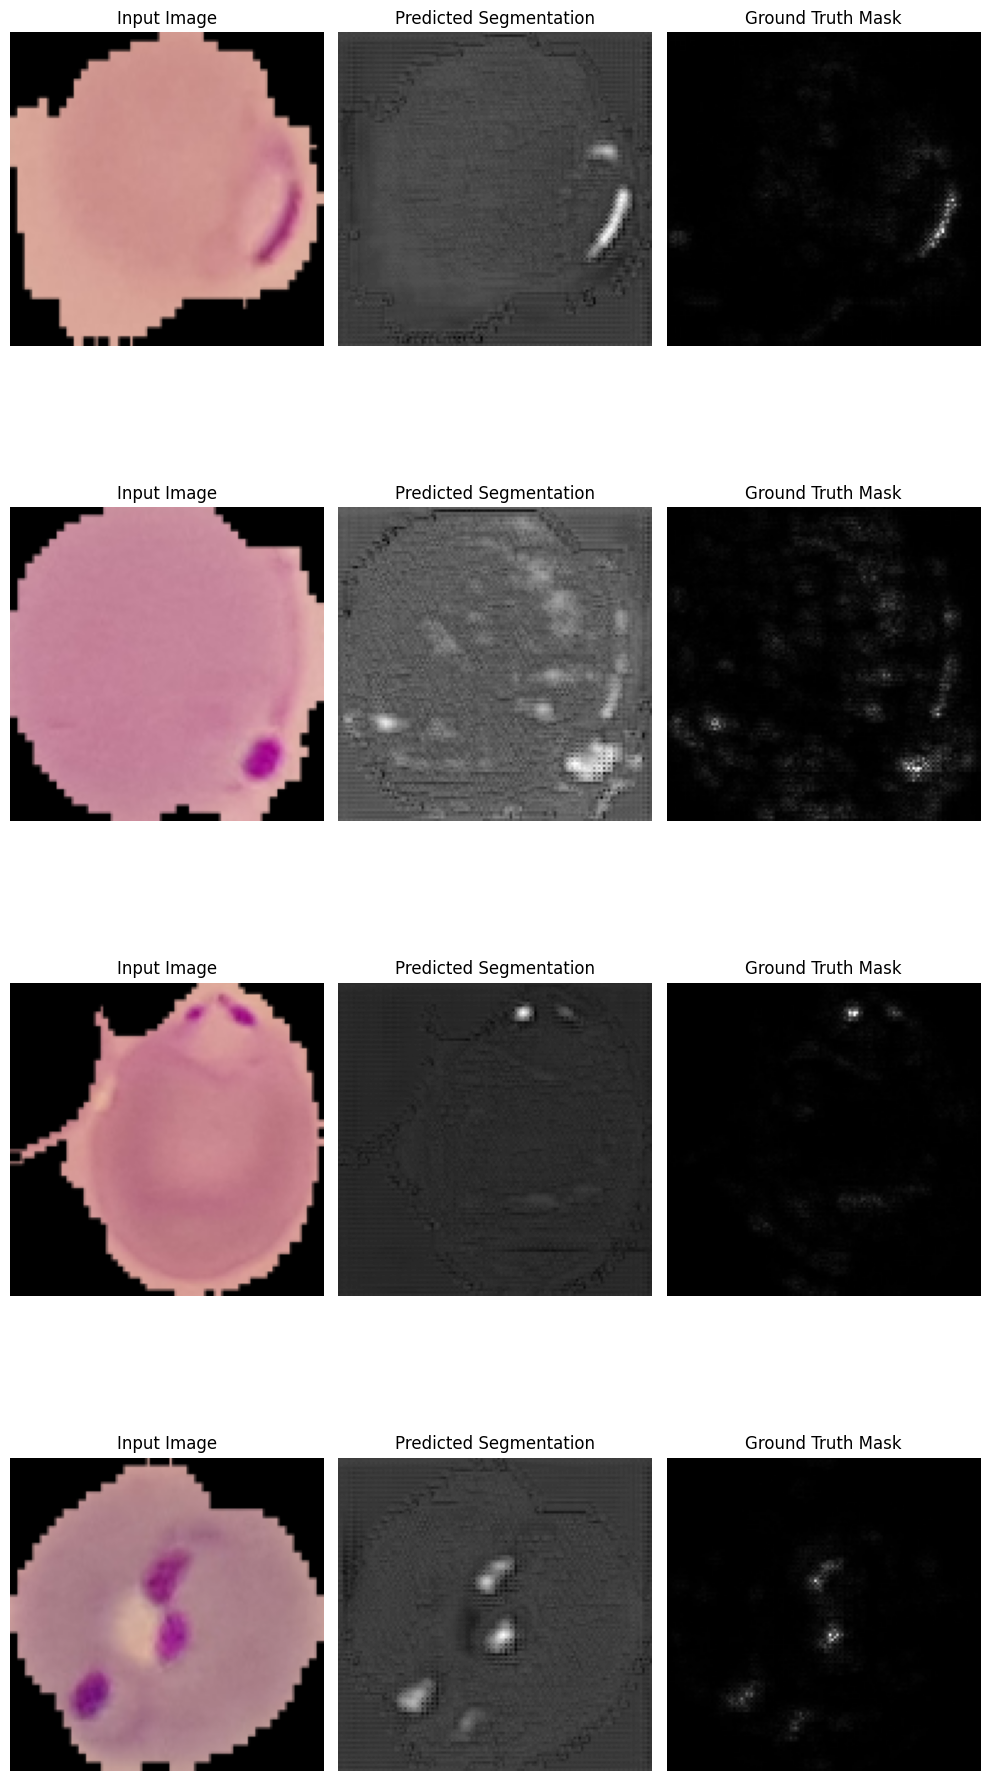

In [17]:
#train images
for images, masks in train_loader:
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ",outputs.shape)
    compare_segmented(images, outputs, masks)
    break

Output shape:  (4, 1, 128, 128)


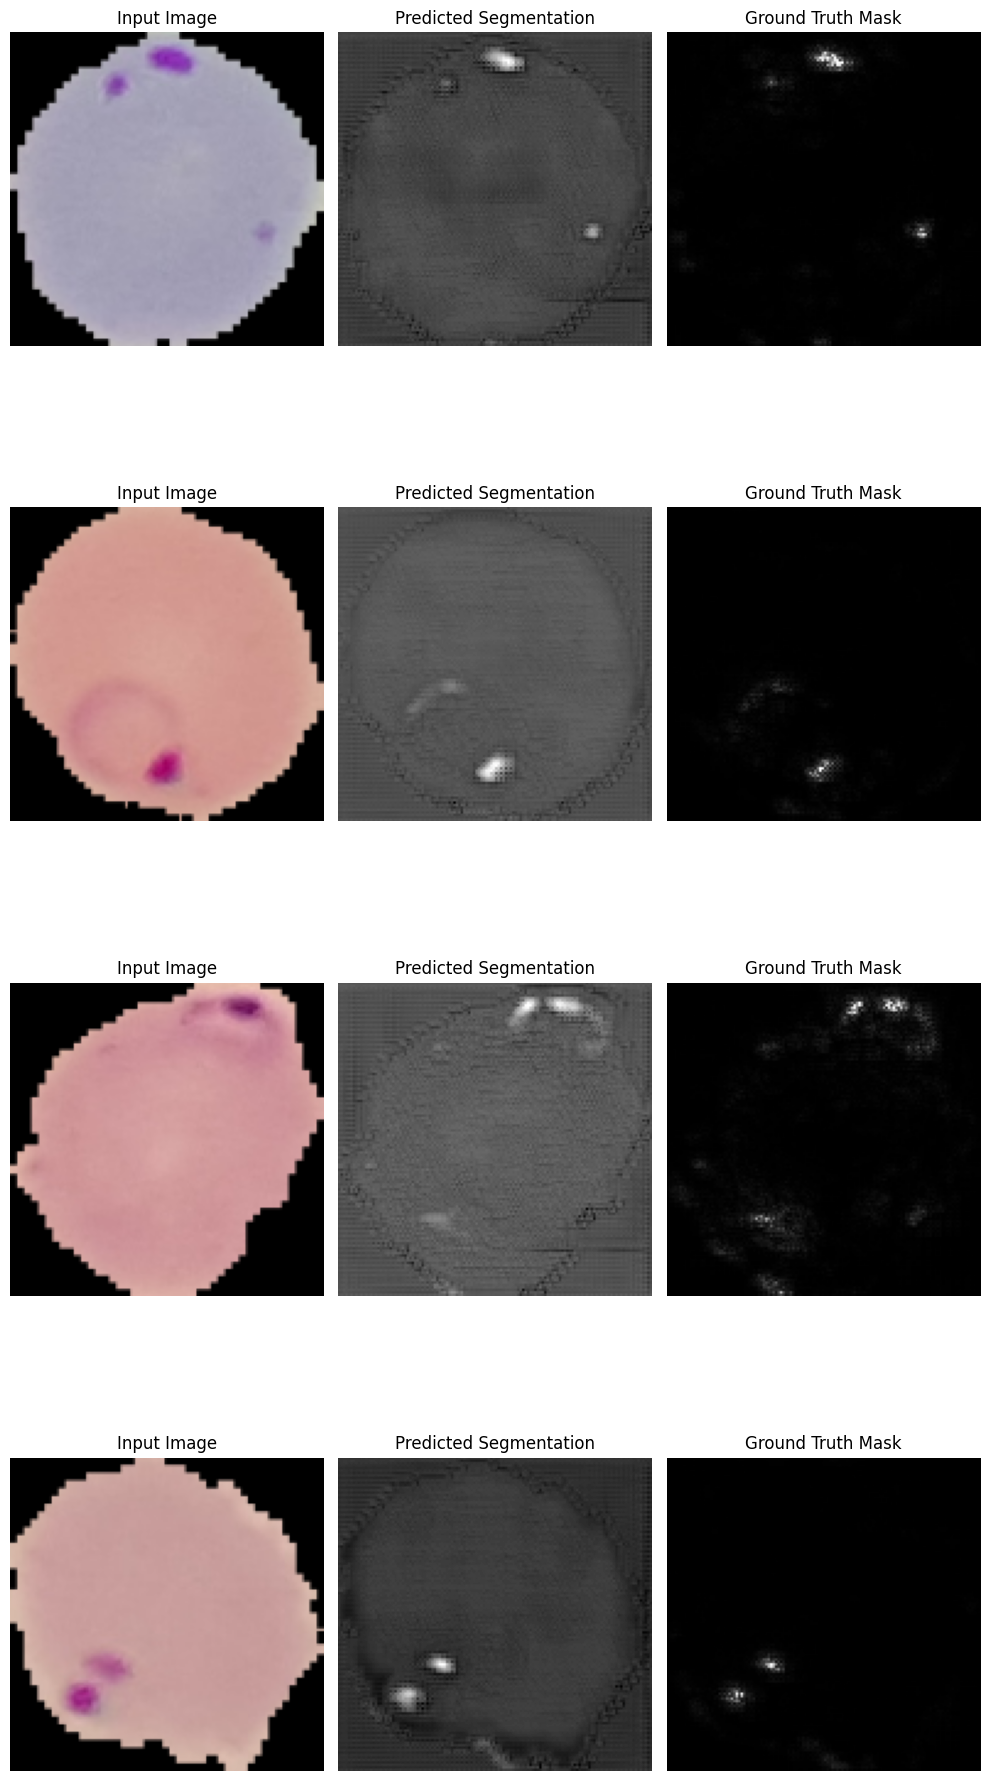

In [18]:
#test images
for images, masks in test_loader:
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ",outputs.shape)
    compare_segmented(images, outputs, masks)
    break

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1227 seconds
Accuracy: 0.9486846923828125
Precision: 0.9655172413793104
Recall: 0.3333333333333333
F1 Score: 0.495575221238938
Sensitivity: 0.3333333333333333
Specificity: 0.9990260812149224
Error Rate: 0.0513153076171875
Confusion Matrix: [[60521    59]
 [ 3304  1652]]


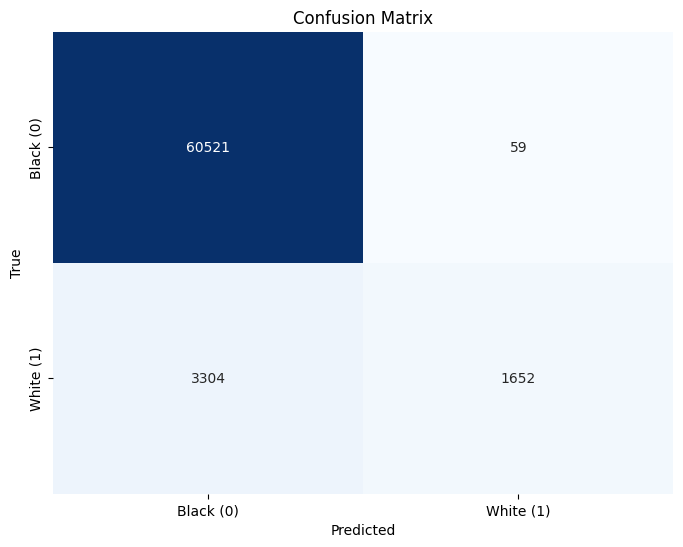

In [19]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.05).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.05).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in train_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1169 seconds
Accuracy: 0.994781494140625
Precision: 0.7107438016528925
Recall: 0.7962962962962963
F1 Score: 0.7510917030567685
Sensitivity: 0.7962962962962963
Specificity: 0.9967636542966342
Error Rate: 0.005218505859375
Confusion Matrix: [[64678   210]
 [  132   516]]


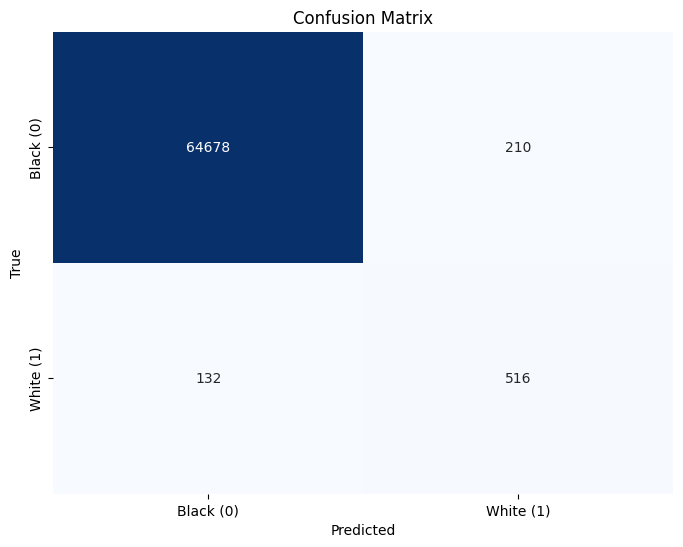

In [20]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.1).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.1).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in train_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1111 seconds
Accuracy: 0.98870849609375
Precision: 0.07151819322459223
Recall: 1.0
F1 Score: 0.13348946135831383
Sensitivity: 1.0
Specificity: 0.9886986667481177
Error Rate: 0.01129150390625
Confusion Matrix: [[64739   740]
 [    0    57]]


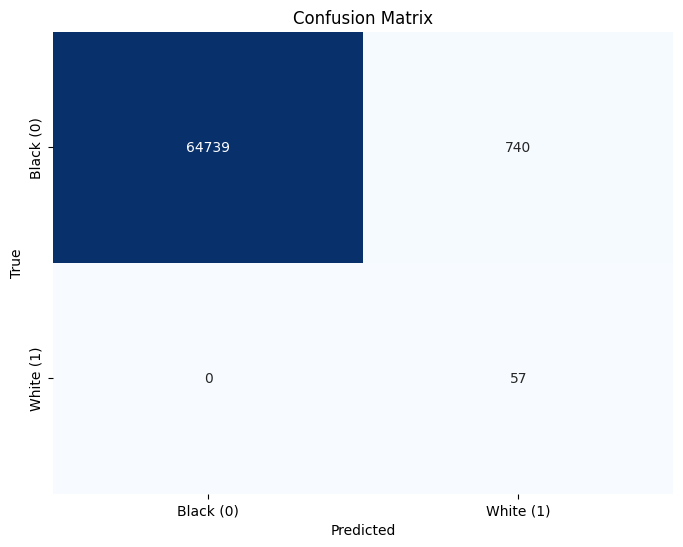

In [21]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.5).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.5).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in train_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1063 seconds
Accuracy: 0.9885101318359375
Precision: 0.11202830188679246
Recall: 1.0
F1 Score: 0.2014846235418876
Sensitivity: 1.0
Specificity: 0.9884934521171742
Error Rate: 0.0114898681640625
Confusion Matrix: [[64688   753]
 [    0    95]]


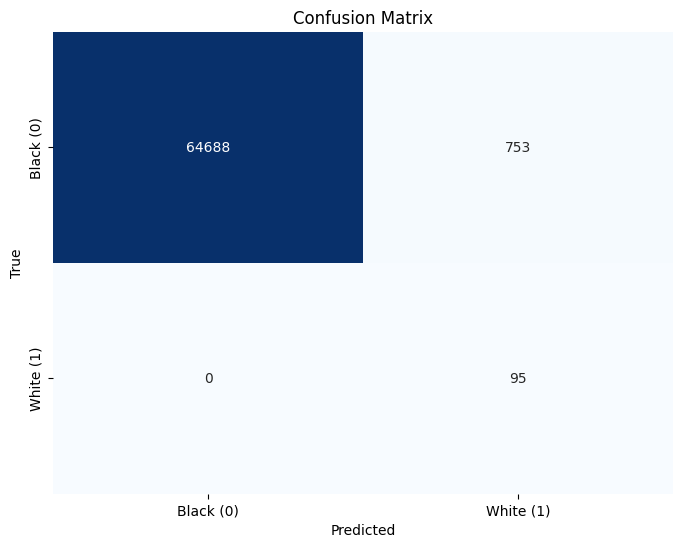

In [22]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.5).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.5).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in test_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1075 seconds
Accuracy: 0.9905242919921875
Precision: 0.7831184056271981
Recall: 0.605072463768116
F1 Score: 0.6826775677056719
Sensitivity: 0.605072463768116
Specificity: 0.9971287558976906
Error Rate: 0.0094757080078125
Confusion Matrix: [[64247   185]
 [  436   668]]


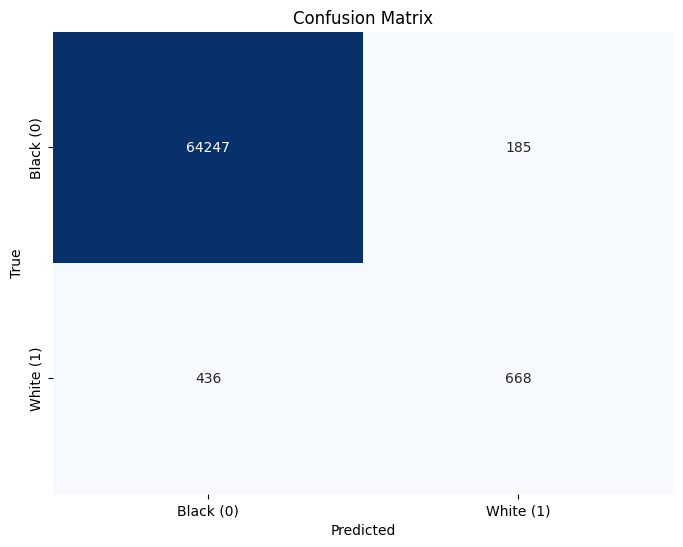

In [23]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.1).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.1).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in test_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1087 seconds
Accuracy: 0.9905242919921875
Precision: 0.7831184056271981
Recall: 0.605072463768116
F1 Score: 0.6826775677056719
Sensitivity: 0.605072463768116
Specificity: 0.9971287558976906
Error Rate: 0.0094757080078125
Confusion Matrix: [[64247   185]
 [  436   668]]


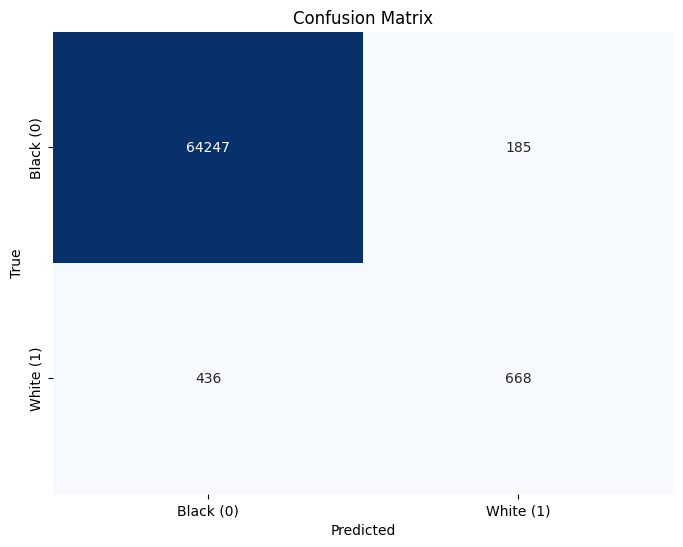

In [24]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.1).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.1).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in test_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset